# Bank Marketing

![](https://images.unsplash.com/photo-1518183214770-9cffbec72538?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1350&q=80)

## Exploring The Data


**Abstract:** The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit.



In [208]:
import warnings
warnings.filterwarnings("ignore")

In [209]:
import findspark

In [210]:
findspark.init("/home/amokrane/spark-2.4.0-bin-hadoop2.7")

In [211]:
from pyspark.sql import SparkSession

In [212]:
spark = SparkSession.builder.appName("bank_marketing").getOrCreate()

## Load Data

In [213]:
df = spark.read.csv("bank.csv", header=True, inferSchema=True)

In [214]:
print((df.count(), len(df.columns)))

(11162, 17)


In [215]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### Have a peek of the first five observations

In [216]:
import pandas as pd

In [217]:
pd.DataFrame(df.take(5), columns=df.columns)

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

### Our Classes are perfect balanced


In [218]:
df.groupBy("deposit").count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



### Summary statistics for numeric variables

In [219]:
df.describe().toPandas()

summary                 age      job   marital education default  \
0   count               11162    11162     11162     11162   11162   
1    mean  41.231947679627304     None      None      None    None   
2  stddev  11.913369192215518     None      None      None    None   
3     min                  18   admin.  divorced   primary      no   
4     max                  95  unknown    single   unknown     yes   

              balance housing   loan   contact                 day  month  \
0               11162   11162  11162     11162               11162  11162   
1  1528.5385235620856    None   None      None  15.658036194230425   None   
2   3225.413325946149    None   None      None   8.420739541006462   None   
3               -6847      no     no  cellular                   1    apr   
4               81204     yes    yes   unknown                  31    sep   

             duration            campaign               pdays  \
0               11162               11162               11162   
1  371.99381831213043   2.508421429851281   51.33040673714388   
2  347.12838571630687  2.7220771816614824  108.75828197197717   
3                   2                   1                  -1   
4                3881                  63                 854   

             previous poutcome deposit  
0               11162    11162   11162  
1  0.8325568894463358     None    None  
2   2.292007218670508     None    None  
3                   0  failure      no  
4                  58  unknown     yes

In [220]:
from pyspark.sql.functions import col,sum
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|      0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+



### Correlations between independent variables.

In [221]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('deposit', 'string')]

In [222]:
numeric_features = [t[0] for t in df.dtypes if t[1] == "int"]

In [223]:
numeric_features

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [224]:
numeric_data = df.select(numeric_features).toPandas()

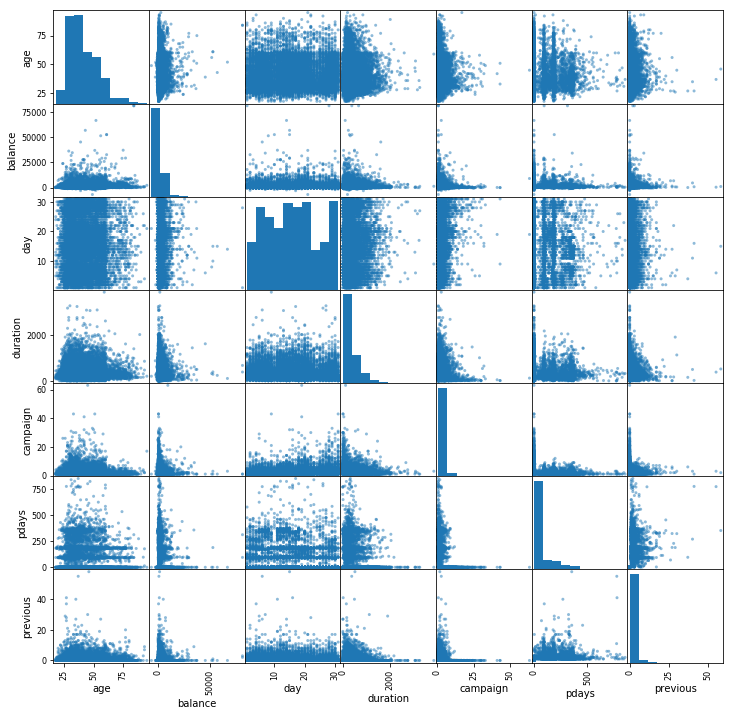

In [225]:
pd.scatter_matrix(numeric_data, figsize=(12, 12));

It's obvious that there aren't highly correlated independent variables. Therefore, we will keep all of them for the model. However, day and month columns are not really useful, we will remove these two columns.



In [226]:
df.columns

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'deposit']

In [227]:
df = df.select(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 
                'duration','campaign', 'pdays', 'previous', 'poutcome', 'deposit'])

In [228]:
df.columns

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'deposit']

In [229]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



## Preprocess Data for Machine Learning

In [230]:
print((df.count(), len(df.columns)))

(11162, 15)


**Since we will have more than 1 stage of feature transformations, we use a Pipeline to tie the stages together. This simplifies our code.**

In [231]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

categoricalColumns = ["job", "marital", "education", "default", "housing", "loan", "contact", "poutcome"]
stages = [] # stages in our Pipeline

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol = "deposit", outputCol = "label")
stages += [label_stringIdx]

# Transform all features into a vector using VectorAssembler
numericCols = ["age", "balance", "duration", "campaign", "pdays", "previous"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

The above code are taken from databricksâ€™ official site and it indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

## Pipeline

In [232]:
cols = df.columns
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ["label", "features"] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [233]:
pd.DataFrame(df.take(5), columns=df.columns)

label                                           features  age         job  \
0    1.0  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   59      admin.   
1    1.0  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   56      admin.   
2    1.0  (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   41  technician   
3    1.0  (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   55    services   
4    1.0  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   54      admin.   

   marital  education default  balance housing loan  contact  duration  \
0  married  secondary      no     2343     yes   no  unknown      1042   
1  married  secondary      no       45      no   no  unknown      1467   
2  married  secondary      no     1270     yes   no  unknown      1389   
3  married  secondary      no     2476     yes   no  unknown       579   
4  married   tertiary      no      184      no   no  unknown       673   

   campaign  pdays  previous poutcome deposit  
0         1     -1         0  unknown     yes  
1         1     -1         0  unknown     yes  
2         1     -1         0  unknown     yes  
3         1     -1         0  unknown     yes  
4         2     -1         0  unknown     yes

In [234]:
### Randomly split data into training and test sets. set seed for reproducibility
train_data, test_data = df.randomSplit([0.7, 0.3], seed=2019)

In [235]:
print("Training Dataset Shape: " + str((train_data.count(), len(train_data.columns))))
print("Test Dataset Shape: " + str((test_data.count(), len(test_data.columns))))

Training Dataset Shape: (7797, 17)
Test Dataset Shape: (3365, 17)


## Logistic Regression Model

In [236]:
from pyspark.ml.classification import LogisticRegression

In [237]:
# Create initial LogisticRegression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

In [238]:
# Train model with Training Data
lr_model = lr.fit(train_data)

### areaUnderROC

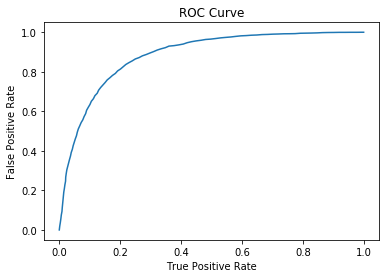

Training set areaUnderROC:0.8831515503967972


In [239]:
import matplotlib.pyplot as plt

roc = training_summary.roc.toPandas()
plt.plot(roc["FPR"],roc["TPR"])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
print("Training set areaUnderROC:" + str(training_summary.areaUnderROC))

### Precision and recall

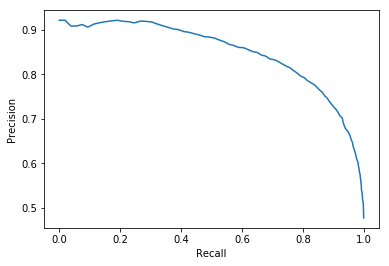

In [240]:
pr = training_summary.pr.toPandas()
plt.plot(pr["recall"],pr["precision"])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

### Make predictions on test data

In [241]:
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
pred = lr_model.transform(test_data)

In [242]:
# View model's predictions and probabilities of each prediction class
pred.select("age", "job", "label", "rawPrediction", "prediction", "probability").show()

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 35|management|  0.0|[1.63812159456029...|       0.0|[0.83727918039749...|
| 37|management|  0.0|[1.05445437906860...|       0.0|[0.74162934441919...|
| 52|management|  0.0|[-0.8716727745112...|       1.0|[0.29490635167306...|
| 53|management|  0.0|[0.82562123019052...|       0.0|[0.69542826671536...|
| 57|management|  0.0|[0.98647603463667...|       0.0|[0.72839131155637...|
| 61|management|  0.0|[0.71967996345092...|       0.0|[0.67253653894510...|
| 46|management|  0.0|[1.97009295122829...|       0.0|[0.87762109670375...|
| 36|management|  0.0|[1.16892454355837...|       0.0|[0.76295056690916...|
| 40|management|  0.0|[1.58245718455187...|       0.0|[0.82955223378154...|
| 40|management|  0.0|[1.39610983075663...|       0.0|[0.80156585169932...|
| 46|managem

## Evaluate our Logistic Regression model

In [243]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [244]:
evaluator = BinaryClassificationEvaluator()

In [245]:
evaluator.getMetricName()

'areaUnderROC'

In [246]:
print("Test Area Under ROC", evaluator.evaluate(pred))

Test Area Under ROC 0.896129916917555


## Decision Tree Classifier

In [247]:
from pyspark.ml.classification import DecisionTreeClassifier

In [248]:
# Create initial Decision Tree Model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

In [249]:
# Train model with Training Data
dt_model = dt.fit(train_data)

In [250]:
# Make predictions on test data using the Transformer.transform() method.
pred = dt_model.transform(test_data)

In [251]:
print("numNodes = ", dt_model.numNodes)
print("depth = ", dt_model.depth)

numNodes =  39
depth =  5


In [252]:
# View model's predictions and probabilities of each prediction class
pred.select("age", "job", "label", "rawPrediction", "prediction", "probability").show()

+---+----------+-----+-------------+----------+--------------------+
|age|       job|label|rawPrediction|prediction|         probability|
+---+----------+-----+-------------+----------+--------------------+
| 35|management|  0.0|[343.0,576.0]|       1.0|[0.37323177366702...|
| 37|management|  0.0|[942.0,362.0]|       0.0|[0.72239263803680...|
| 52|management|  0.0|[207.0,609.0]|       1.0|[0.25367647058823...|
| 53|management|  0.0|[942.0,362.0]|       0.0|[0.72239263803680...|
| 57|management|  0.0|[942.0,362.0]|       0.0|[0.72239263803680...|
| 61|management|  0.0|[942.0,362.0]|       0.0|[0.72239263803680...|
| 46|management|  0.0| [692.0,14.0]|       0.0|[0.98016997167138...|
| 36|management|  0.0| [349.0,20.0]|       0.0|[0.94579945799458...|
| 40|management|  0.0| [349.0,20.0]|       0.0|[0.94579945799458...|
| 40|management|  0.0| [349.0,20.0]|       0.0|[0.94579945799458...|
| 46|management|  0.0|  [56.0,21.0]|       0.0|[0.72727272727272...|
| 56|management|  0.0|[805.0,116.0

## Evaluate our Decision Tree model

In [253]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC", evaluator.evaluate(pred))

Test Area Under ROC 0.8015948975203022


## Random Forest Classifier

In [125]:
from pyspark.ml.classification import RandomForestClassifier

In [254]:
# Create an initial RandomForest model.
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

In [255]:
# Train model with Training Data
rf_model = rf.fit(train_data)

In [256]:
# Make predictions on test data using the Transformer.transform() method.
pred = rf_model.transform(test_data)

In [257]:
# View model's predictions and probabilities of each prediction class
pred.select("age", "job", "label", "rawPrediction", "prediction", "probability").show()

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 35|management|  0.0|[11.2542133392785...|       0.0|[0.56271066696392...|
| 37|management|  0.0|[14.5001744040323...|       0.0|[0.72500872020161...|
| 52|management|  0.0|[6.80939812123172...|       1.0|[0.34046990606158...|
| 53|management|  0.0|[13.7675137367837...|       0.0|[0.68837568683918...|
| 57|management|  0.0|[14.5001744040323...|       0.0|[0.72500872020161...|
| 61|management|  0.0|[9.01917860190714...|       1.0|[0.45095893009535...|
| 46|management|  0.0|[15.5498900717790...|       0.0|[0.77749450358895...|
| 36|management|  0.0|[13.8818041670232...|       0.0|[0.69409020835116...|
| 40|management|  0.0|[14.0810744138198...|       0.0|[0.70405372069099...|
| 40|management|  0.0|[13.9117610635749...|       0.0|[0.69558805317874...|
| 46|managem

## Evaluate our Random Forest Classifier

In [258]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC", evaluator.evaluate(pred))

Test Area Under ROC 0.8890633672164296


## Gradient-Boosted Tree Classifier

In [132]:
from pyspark.ml.classification import GBTClassifier

In [259]:
# Create an initial Gradient-Boosted Tree Classifier model.
gbt = GBTClassifier()

In [260]:
# Train model with Training Data
gbt_model = gbt.fit(train_data)

In [261]:
# Make predictions on test data using the Transformer.transform() method.
pred = gbt_model.transform(test_data)

In [262]:
# View model's predictions and probabilities of each prediction class
pred.select("age", "job", "label", "rawPrediction", "prediction", "probability").show()

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 35|management|  0.0|[0.11036114547543...|       0.0|[0.55495763335345...|
| 37|management|  0.0|[0.55293033216090...|       0.0|[0.75135660619768...|
| 52|management|  0.0|[-0.6199086667865...|       1.0|[0.22446778306691...|
| 53|management|  0.0|[0.00526868102788...|       0.0|[0.50263431613866...|
| 57|management|  0.0|[0.57029688194365...|       0.0|[0.75778863808793...|
| 61|management|  0.0|[-0.4761184336476...|       1.0|[0.27843519247116...|
| 46|management|  0.0|[1.54213711365519...|       0.0|[0.95623939147897...|
| 36|management|  0.0|[1.11725342917770...|       0.0|[0.90330572441752...|
| 40|management|  0.0|[0.83524190197684...|       0.0|[0.84164031412175...|
| 40|management|  0.0|[1.15574818966171...|       0.0|[0.90982469912874...|
| 46|managem

## Evaluate our Gradient-Boosted Tree Classifier

In [263]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC", evaluator.evaluate(pred))

Test Area Under ROC 0.9078896379036432


**Gradient-Boosted Tree achieved the best results, we will try tuning this model with the ParamGridBuilder and the CrossValidator.**

### Print a list of all params and their definitions

In [264]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

## Tuning the best model 

In [265]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [266]:
param_Grid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

In [267]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=gbt, estimatorParamMaps=param_Grid, evaluator=evaluator, numFolds=5)

In [268]:
# Run cross validations.
cv_model = cv.fit(train_data)

In [270]:
# Use test set here so we can measure the accuracy of our model on new data
pred = cv_model.transform(test_data)

In [271]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test Area Under ROC", evaluator.evaluate(pred))

Test Area Under ROC 0.9085021455511194


## Make Predictions

In [272]:
best_model = cv_model.bestModel

In [275]:
# Generate predictions for entire dataset
final_pred = best_model.transform(df)

In [277]:
# Evaluate best model
print("Test Area Under ROC", evaluator.evaluate(final_pred))

Test Area Under ROC 0.9067680023792257
